In [145]:
# Authors: Corinne Kleinman and Gabriel Mersy
import tensorflow as tf
from tensorflow import keras
import os
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np
import pandas as pd
import sklearn.model_selection
import matplotlib.pyplot as plt

In [146]:
# Setting seed for reproducible results
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

In [147]:
# Reading in data
dat = pd.read_csv('./demographicDataCleanMerged11.csv', sep = ',')
dat.head()

,percent_with_internet_subscription,education_25_older_bachelor's_degree,household_median_income,percent_with_disability,total_moved_to_US_from_abroad,Percent_Very_Religious,Percent_Nonreligious,mass_shootings,believes_climate_change,senate_polarization
0,64.721508,14.8,42849,15.9,14928,57,15,1,63.450,0.929447
1,79.882121,18.2,72237,11.1,7081,38,35,0,69.588,0.880214
2,74.841647,17.1,48510,12.3,44711,36,35,1,68.827,1.439661
3,62.302302,13.4,40511,17.1,9377,51,19,0,64.120,0.554589
4,78.750678,19.5,60190,10.6,291448,34,37,4,75.241,1.538937


In [148]:
# Train-test split
train, test = sklearn.model_selection.train_test_split(dat, test_size = 0.2, train_size = 0.8)

In [149]:
# Popping the labels under consideration
train_label = train.pop('senate_polarization')
test_label = test.pop('senate_polarization')

In [150]:
# Normalizing train features
stats = train.describe()
stats = stats.transpose()

def normalize(val):
    return((val - stats['mean']) / (stats['std']))

normTrainFeatures = normalize(train)

normTrainFeatures.head()

,percent_with_internet_subscription,education_25_older_bachelor's_degree,household_median_income,percent_with_disability,total_moved_to_US_from_abroad,Percent_Very_Religious,Percent_Nonreligious,mass_shootings,believes_climate_change
153,-0.401570,1.705499,1.072746,-1.031287,-0.159451,-0.049657,-0.152386,-0.017854,0.205642
47,1.020013,-0.070592,1.669380,-0.937946,-0.627237,-1.390386,1.988453,-0.532063,0.368208
84,-0.024416,-0.146171,-0.179944,-0.704594,3.193395,0.062071,0.115219,-0.017854,0.199704
117,0.381751,0.118354,-0.698908,0.322156,0.131939,1.179345,-1.133604,2.038979,0.205889
178,-0.793231,0.269510,0.196541,-0.564583,-0.343281,-0.049657,0.026017,-0.532063,0.006208


In [151]:
# Building feed forward neural network model with single hidden layer
def buildModel():
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(5, input_dim = 9)) 
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dense(1))
    
    model.compile(optimizer=keras.optimizers.Adam(), loss='mse', 
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    
    return model

Train on 96 samples, validate on 48 samples
Epoch 1/500
96/96 [==============================] - 0s 2ms/sample - loss: 1.0510 - rmse: 1.0252 - val_loss: 1.3105 - val_rmse: 1.1448
Epoch 2/500
96/96 [==============================] - 0s 82us/sample - loss: 1.0239 - rmse: 1.0119 - val_loss: 1.2727 - val_rmse: 1.1281
Epoch 3/500
96/96 [==============================] - 0s 125us/sample - loss: 0.9945 - rmse: 0.9973 - val_loss: 1.2363 - val_rmse: 1.1119
Epoch 4/500
96/96 [==============================] - 0s 119us/sample - loss: 0.9676 - rmse: 0.9837 - val_loss: 1.2010 - val_rmse: 1.0959
Epoch 5/500
96/96 [==============================] - 0s 110us/sample - loss: 0.9410 - rmse: 0.9701 - val_loss: 1.1672 - val_rmse: 1.0804
Epoch 6/500
96/96 [==============================] - 0s 106us/sample - loss: 0.9157 - rmse: 0.9569 - val_loss: 1.1342 - val_rmse: 1.0650
Epoch 7/500
96/96 [==============================] - 0s 85us/sample - loss: 0.8905 - rmse: 0.9437 - val_loss: 1.1020 - val_rmse: 1.0497
E

Text(0.5, 1.0, 'Error in Senate Polarity Training Model by Epoch Number')

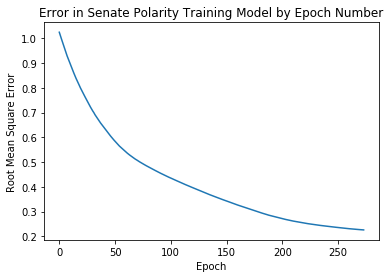

In [152]:
# Training house polarity model
modSen = buildModel()

stopCallBack = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
trainedModSen = modSen.fit(normTrainFeatures, train_label, epochs=500, verbose=1, 
                       validation_split = 0.33,
                       callbacks=[stopCallBack])

res = pd.DataFrame(trainedModSen.history)
res['epoch'] = trainedModSen.epoch

# Plotting RMSE and Epoch number
x = res['epoch']
y = res['rmse']

plt.plot(x, y)
plt.xlabel('Epoch')
plt.ylabel('Root Mean Square Error')
plt.title('Error in Senate Polarity Training Model by Epoch Number')

In [153]:
# Normalizing test features
stats_test = train.describe()
stats_test = stats.transpose()

def normalize_test(val):
    return((val - stats_test['mean']) / (stats_test['std']))

normTestFeatures = normalize(test)

In [154]:
# Testing data
score= modSen.evaluate(normTestFeatures, test_label, verbose=2)
print(score)

36/36 - 0s - loss: 0.0771 - rmse: 0.2777
[0.07713987761073643, 0.2777407]


In [155]:
# Predictions for test set 
pred = modSen.predict(normTestFeatures)
results = pd.DataFrame(pred, test_label)
results

,0
senate_polarization,
1.094881,0.930912
0.811150,0.717057
0.931738,1.234690
1.163673,0.865882
1.029827,0.795890
0.926856,1.008331
0.810126,0.748453
1.076631,0.764415
0.979597,0.681693


In [156]:
# Importing prediction data for 2017
predDat2017 = pd.read_csv('./2017Data.csv')
predDat2017.head()

,state_name,percent_with_internet_subscription,percent_private_health_insurance,education_25_older_bachelor's_degree,count_bach,total_bach,household_median_income,total_moved_to_US_from_abroad,Percent_Very_Religious,Percent_Nonreligious,mass_shootings,believes_climate_change,percent_with_disability
0,Alabama,78.5,66.9,25.522789,844704,3309607,48123,13667,54,17,9,63.3020,16.5
1,Alaska,86.4,63.2,28.798844,138684,481561,73181,6703,28,47,0,69.1040,12.6
2,Arizona,86.0,63.0,29.356522,1383092,4711362,56581,45322,31,39,8,69.3910,13.0
3,Arkansas,73.3,61.3,23.407412,470114,2008398,45869,8958,50,19,3,63.6665,18.0
4,California,87.9,63.6,33.645021,8976247,26679273,71805,318752,29,41,49,75.7115,10.6


In [157]:
# Saving state_name for future use
stateName = predDat2017.pop('state_name')

res2017 = pd.DataFrame(stateName)


In [158]:
# Removing unnecesary columns
predDat2017.pop('count_bach')
predDat2017.pop('total_bach')
predDat2017.pop('percent_private_health_insurance')
predDat2017.head()

,percent_with_internet_subscription,education_25_older_bachelor's_degree,household_median_income,total_moved_to_US_from_abroad,Percent_Very_Religious,Percent_Nonreligious,mass_shootings,believes_climate_change,percent_with_disability
0,78.5,25.522789,48123,13667,54,17,9,63.3020,16.5
1,86.4,28.798844,73181,6703,28,47,0,69.1040,12.6
2,86.0,29.356522,56581,45322,31,39,8,69.3910,13.0
3,73.3,23.407412,45869,8958,50,19,3,63.6665,18.0
4,87.9,33.645021,71805,318752,29,41,49,75.7115,10.6


In [159]:
# Normalizing 2017 features 
stats2017 = predDat2017.describe()
stats2017 = stats2017.transpose()

def normalize(value):
    return((value - stats2017['mean']) / (stats2017['std']))

normPred2017Feat = normalize(predDat2017)

normPred2017Feat.head()


,percent_with_internet_subscription,education_25_older_bachelor's_degree,household_median_income,total_moved_to_US_from_abroad,Percent_Very_Religious,Percent_Nonreligious,mass_shootings,believes_climate_change,percent_with_disability
0,-1.230910,-1.076881,-1.184158,-0.452332,1.861818,-1.722462,0.054419,-1.120732,1.405684
1,0.857618,-0.447650,1.358571,-0.561735,-1.012723,1.281832,-0.790008,0.197327,-0.313942
2,0.751870,-0.340538,-0.325893,0.044966,-0.681045,0.480687,-0.039407,0.262526,-0.137570
3,-2.605637,-1.483180,-1.412880,-0.526310,1.419581,-1.522176,-0.508532,-1.037928,2.067079
4,1.254174,0.483153,1.218944,4.340528,-0.902164,0.680974,3.807426,1.698375,-1.195802


In [144]:
# Obtaining predictions for 2017 
predictions2017 = modSen.predict(normPred2017Feat)
predictions2017

array([[1.3241229 ],
       [0.88702285],
       [0.92496943],
       [1.268015  ],
       [3.1092749 ],
       [1.1198239 ],
       [0.9083997 ],
       [0.7381938 ],
       [1.857679  ],
       [0.81153524],
       [0.8593426 ],
       [1.0203768 ],
       [1.8614208 ],
       [0.9001738 ],
       [0.8931397 ],
       [0.9280355 ],
       [1.0846874 ],
       [1.0119878 ],
       [1.5268402 ],
       [1.18024   ],
       [1.4937065 ],
       [0.8101955 ],
       [0.7213495 ],
       [1.3731109 ],
       [0.7602608 ],
       [0.7619982 ],
       [1.2477144 ],
       [0.83476365],
       [0.9873085 ],
       [1.3115368 ],
       [0.91040707],
       [1.7073227 ],
       [0.8433254 ],
       [1.1189576 ],
       [1.072735  ],
       [1.1733745 ],
       [1.0470161 ],
       [1.0494759 ],
       [0.7400255 ],
       [1.0855604 ],
       [0.9907613 ],
       [0.9941629 ],
       [1.4302924 ],
       [1.4100585 ],
       [1.6856555 ],
       [1.0866939 ],
       [1.2013572 ],
       [1.181

In [160]:
# Setting up dataframe with state name and 2017 predictions
res2017['senate_polarization'] = predictions2017

# Writing results to .csv 
res2017.to_csv('./2017ResultsSenate.csv', sep =',')